In [1]:
import numpy as np
import matplotlib.pyplot as plt

from TidalPy.RadialSolver import radial_solver
from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays

In [86]:
# Recreate results of Guo+ 2004 (https://academic.oup.com/gji/article/159/1/53/1996045)
# Uses PREM model of Earth with averaged continental and ocean crust
# LNs taken from table 1 of Guo+ 2004 GJI
guo_data = np.loadtxt("Guo+2004.csv", delimiter=",", dtype=np.float64)

# Convert to SI
r   = guo_data[0,:] * 1000.
vp  = guo_data[1,:] * 1000.
vs  = guo_data[2,:] * 1000.
rho = guo_data[3,:] * 1000.

# Convert Seismic Velocities to Elastic Moduli
mu   = vs**2 * rho
K    = (vp**2 * rho) - (4. / 3.) * mu
lame = K - (2. / 3.) * mu
eta  = 1.0e30 * np.ones_like(mu)

# Convert inputs to correct array types
radius_array    = np.asarray(r, dtype=np.float64, order='C')
shear_array     = np.asarray(mu, dtype=np.float64, order='C')
viscosity_array = np.asarray(eta, dtype=np.float64, order='C')
bulk_mod_array  = np.asarray(K, dtype=np.complex128, order='C')
density_array   = np.asarray(rho, dtype=np.float64, order='C')

# Prepend r=0, just using the same values as the lowest r from before
radius_array    = np.insert(radius_array, 0, 0.0, axis=0)
shear_array     = np.insert(shear_array, 0, shear_array[0], axis=0)
viscosity_array = np.insert(viscosity_array, 0, viscosity_array[0], axis=0)
bulk_mod_array  = np.insert(bulk_mod_array, 0, bulk_mod_array[0], axis=0)
density_array   = np.insert(density_array, 0, density_array[0], axis=0)

# Define planetary parameters
forcing_frequency = 2. * np.pi / (24 * 60 * 60)
planet_mass       = 5.972e24  # [m]
planet_radius     = 6.371e6   # [kg]
surface_pressure  = 0.0 # 101_325   # [Pa]
planet_volume = (4. / 3.) * np.pi * (planet_radius**3)
planet_bulk_density = planet_mass / planet_volume

upper_radius_by_layer=np.asarray((1.2225E+06, 3.4810E+06, 6.3710e+06), dtype=np.float64)
# upper_radius_by_layer=np.asarray((1.3010E+06, 3.4810E+06, 6.3710e+06), dtype=np.float64)

density_array[radius_array <= upper_radius_by_layer[0]] = 11000.0
density_array[np.logical_and(radius_array <= upper_radius_by_layer[1], radius_array > upper_radius_by_layer[0])] = 8500.0
density_array[np.logical_and(radius_array <= upper_radius_by_layer[2], radius_array > upper_radius_by_layer[1])] = 3000.0

In [ ]:
# Purely Elastic Body
from TidalPy.rheology import Elastic

elastic_rheology = Elastic()
# Calculate the "complex" shear (really all Im[shear_modulus] = 0)
complex_shear = np.empty(radius_array.shape, dtype=np.complex128)
# shear_array = np.ascontiguousarray(shear_array)
# viscosity_array = np.ascontiguousarray(viscosity_array)
elastic_rheology.vectorize_modulus_viscosity(forcing_frequency, shear_array, viscosity_array, complex_shear)


nmax=18

degs = np.arange(1,nmax+1)
kp_i = np.zeros(nmax, dtype=np.complex128)
hp_i = np.zeros(nmax, dtype=np.complex128)
kl_i = np.zeros(nmax, dtype=np.complex128)
hl_i = np.zeros(nmax, dtype=np.complex128)

kp_c = np.zeros(nmax, dtype=np.complex128)
hp_c = np.zeros(nmax, dtype=np.complex128)
kl_c = np.zeros(nmax, dtype=np.complex128)
hl_c = np.zeros(nmax, dtype=np.complex128)


for degree_l in degs:
    radial_solution_incomp = \
        radial_solver(
            radius_array,
            density_array,
            bulk_mod_array,
            complex_shear,
            forcing_frequency,
            planet_bulk_density,
            layer_types=("solid","liquid","solid"),
            is_static_bylayer=(False,True,False),
            is_incompressible_bylayer=(False,True,True),
            upper_radius_bylayer_array=upper_radius_by_layer,
            surface_pressure = surface_pressure,
            degree_l=degree_l,
            solve_for=('tidal',),
            use_kamata=False,
            starting_radius = 10.0,
            start_radius_tolerance = 1.0e-5,
            integration_method='RK45',
            integration_rtol = 1.0e-8,
            integration_atol = 1.0e-12,
            scale_rtols_bylayer_type = False,
            max_num_steps = 1_000_000,
            expected_size = 1000,
            max_ram_MB = 4000,
            max_step = 0,
            nondimensionalize = False,
            use_prop_matrix = False,
            verbose = False,
            warnings = False,
            raise_on_fail = False,
            eos_method_bylayer = None,
            eos_integration_method = 'DOP853',
            eos_rtol = 1.0e-8,
            eos_atol = 1.0e-14,
            eos_pressure_tol = 1.0e-2,
            eos_max_iters = 350,
            perform_checks = True
            )
    if not radial_solution_incomp.success:
        import pdb; pdb.set_trace()
        print(radial_solution_incomp.message)
        raise Exception(f"Incomp Solver Failed at l = {degree_l}.")

    from TidalPy.utilities.graphics.multilayer import yplot
    yplot(radial_solution_incomp.result, radius_array)

    if degree_l==1:
        import pdb; pdb.set_trace()
        kp_i[degree_l-1] = radial_solution_incomp.k[0]-radial_solution_incomp.k[0]
        hp_i[degree_l-1] = radial_solution_incomp.h[0]-radial_solution_incomp.k[0]
        kl_i[degree_l-1] = radial_solution_incomp.k[1]-radial_solution_incomp.k[1]
        hl_i[degree_l-1] = radial_solution_incomp.h[1]-radial_solution_incomp.k[1]
    else:
        kp_i[degree_l-1] = radial_solution_incomp.k[0]
        hp_i[degree_l-1] = radial_solution_incomp.h[0]
        kl_i[degree_l-1] = radial_solution_incomp.k[1]
        hl_i[degree_l-1] = radial_solution_incomp.h[1]
    
    radial_solution_compress = \
        radial_solver(
            radius_array,
            density_array,
            bulk_mod_array,
            complex_shear,
            forcing_frequency,
            planet_bulk_density,
            layer_types=("liquid","solid","solid"),
            is_static_bylayer=(True,False,False),
            is_incompressible_bylayer=(False,False,False),
            upper_radius_bylayer_array=upper_radius_by_layer,
            surface_pressure = surface_pressure,
            degree_l=degree_l,
            solve_for=('tidal','loading'),
            use_kamata=True,
            starting_radius = 1.0e5,
            start_radius_tolerance = 1.0e-5,
            integration_method='DOP853',
            integration_rtol = 1.0e-8,
            integration_atol = 1.0e-10,
            scale_rtols_bylayer_type = False,
            max_num_steps = 1_000_000,
            expected_size = 1000,
            max_ram_MB = 1000,
            max_step = 0,
            nondimensionalize = True,
            use_prop_matrix = False,
            verbose = False,
            warnings = False,
            raise_on_fail = False,
            eos_method_bylayer = None,
            eos_integration_method = 'DOP853',
            eos_rtol = 1.0e-4,
            eos_atol = 1.0e-12,
            eos_pressure_tol = 1e3,
            eos_max_iters = 50,
            perform_checks = True
            )

    if not radial_solution_compress.success:
        raise Exception(f"Compress Solver Failed at l = {degree_l}.")

    if degree_l==1:
        kp_c[degree_l-1] = radial_solution_compress.k[0]-radial_solution_compress.k[0]
        hp_c[degree_l-1] = radial_solution_compress.h[0]-radial_solution_compress.k[0]
        kl_c[degree_l-1] = radial_solution_compress.k[1]-radial_solution_compress.k[1]
        hl_c[degree_l-1] = radial_solution_compress.h[1]-radial_solution_compress.k[1]
    else:
        kp_c[degree_l-1] = radial_solution_compress.k[0]
        hp_c[degree_l-1] = radial_solution_compress.h[0]
        kl_c[degree_l-1] = radial_solution_compress.k[1]
        hl_c[degree_l-1] = radial_solution_compress.h[1]
    
    # print(degree_l)


guo_n  = np.array([1, 2, 3, 4, 5, 6, 8, 10, 18])
guo_h  = -np.array([0.2856, 0.9909, 1.0501, 1.0528, 1.0857, 1.1433, 1.2833, 1.4226, 1.8733])
guo_kn = -np.array([0, 0.6103, 0.5876, 0.5341, 0.5228, 0.5411, 0.61107, 0.6893, 0.961])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(degs,hl_i,'-.',label="incompressible",ms=8,color='red')
plt.plot(degs,hl_c,'-.',label="compressible",ms=8,color='blue')
plt.plot(guo_n,guo_h,'x',label="Guo+ (2004)",ms=8,color='black')
plt.xticks(np.arange(0, nmax,1))
plt.xlim([1,nmax])
plt.tick_params(labelsize='large')
plt.title('Load Love Numbers $(h^\prime)$',fontsize = 'xx-large')
plt.xlabel('$n$',fontsize='xx-large')
plt.grid()

plt.subplot(1,2,2)
plt.plot(degs,kl_i,'-.',label="incompressible",ms=8,color='red')
plt.plot(degs,kl_c,'-.',label="compressible",ms=8,color='blue')
plt.plot(guo_n,guo_kn/guo_n,'x',label="Guo+ (2004)",ms=8,color='black')

plt.xticks(np.arange(0, nmax,1))
plt.xlim([2,nmax])
plt.tick_params(labelsize='large')

plt.legend(loc='best',fontsize='12',ncol=1)
plt.title('Load Love Numbers $(k^\prime)$',fontsize = 'xx-large')
plt.xlabel('$n$',fontsize='xx-large')
plt.grid()
plt.tight_layout()
plt.show()
    

None
> c:\users\joepr\appdata\local\temp\ipykernel_8768\4156444308.py(68)<module>()



In [10]:
# Now lets do an older model, from Farrell (1972) using the Gutenberg Earth model of Alterman+ 1961

r = np.array([0, 19, 38, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 225,
              250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1200,
              1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 2898, 3000,
              3500, 4000, 4500, 4982, 5121, 6370])


rho = np.array([2.74, 3.00, 3.32, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.41,
                3.43, 3.46, 3.48, 3.50, 3.53, 3.58, 3.62, 3.69, 3.82, 4.01,
                4.21, 4.40, 4.56, 4.63, 4.74, 4.85, 4.96, 5.07, 5.19, 5.29,
                5.39, 5.49, 5.59, 5.69, 9.40, 9.55, 10.15, 10.7, 11.2, 11.5,
                12.0, 12.3])

vp = np.array([6.14, 6.58, 8.20, 8.17, 8.14, 8.10, 8.07, 8.02, 7.93, 7.85, 
               7.89, 7.98, 8.10, 8.21, 8.38, 8.62, 8.87, 9.15, 9.45, 9.88, 
               10.30, 10.71, 11.10, 11.35, 11.60, 11.93, 12.17, 12.43, 12.67,
               12.90, 13.10, 13.32, 13.59, 13.70, 8.10, 8.23, 8.90, 9.50, 
               9.97, 10.44, 10.75, 11.31])

vs = np.array([3.55, 3.80, 4.65, 4.62, 4.57, 4.51, 4.46, 4.41, 4.37, 4.35, 
               4.36, 4.38, 4.42, 4.46, 4.45, 4.68, 4.85, 5.04, 5.21, 5.45, 
               5.76, 6.03, 6.23, 6.32, 6.42, 6.55, 6.69, 6.80, 6.90, 6.97, 
               7.05, 7.15, 7.23, 7.20, 0., 0., 0., 0., 0., 0., 0., 0.])


if (r[0] < r[-1]):
    print(":: Reversing model to start from core")
    r = r[::-1]
    vp = vp[::-1]
    vs = vs[::-1]
    rho = rho[::-1]
r = 6371-r

r   = r * 1000.
vp  = vp * 1000.
vs  = vs * 1000.
rho = rho * 1000.

# Convert Seismic Velocities to Elastic Moduli
mu   = vs**2 * rho
K    = vp**2 * rho - (4. / 3.) * mu
lame = K - (2. / 3.) * mu
eta  = 1E30 * np.ones_like(mu)

:: Reversing model to start from core


c:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


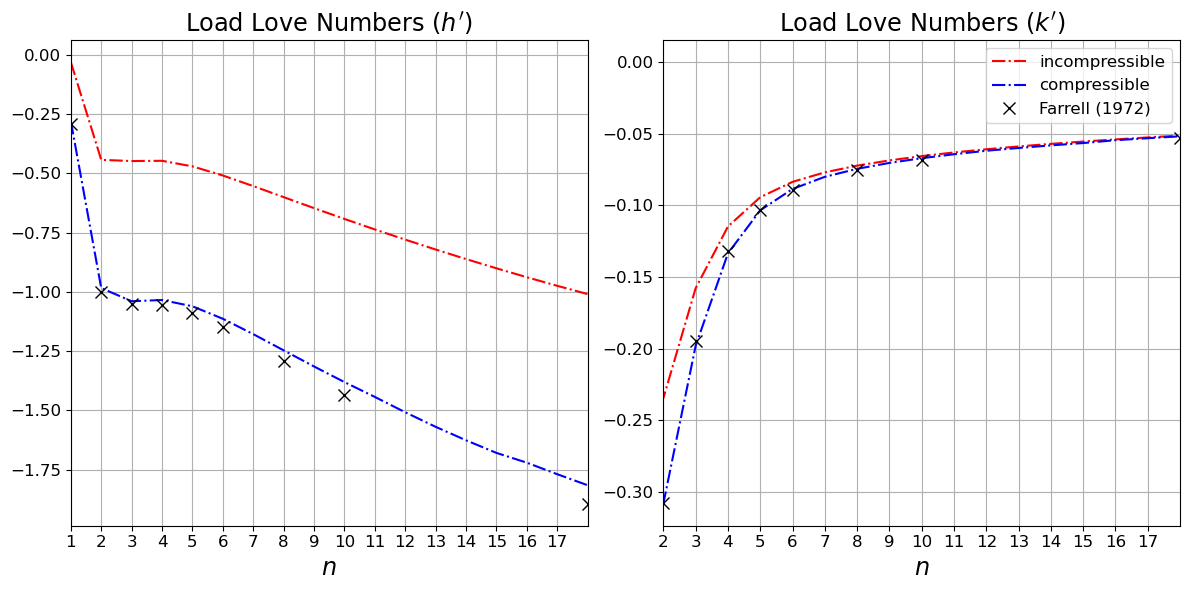

In [12]:
forcing_frequency = 2. * np.pi / (24 * 60 * 60) 

# Convert inputs to correct array types
radius_array    = np.asarray(r, dtype=np.float64, order='C')
shear_array     = np.asarray(mu, dtype=np.float64, order='C')
viscosity_array = np.asarray(eta, dtype=np.float64, order='C')
bulk_mod_array  = np.asarray(K, dtype=np.complex128, order='C')
density_array   = np.asarray(rho, dtype=np.float64, order='C')
    
# Purely Elastic Body
from TidalPy.rheology import Elastic

elastic_rheology = Elastic()
# Calculate the "complex" shear (really all Im[shear_modulus] = 0)
complex_shear = np.empty(radius_array.shape, dtype=np.complex128)
shear_array = np.ascontiguousarray(shear_array)
viscosity_array = np.ascontiguousarray(viscosity_array)
elastic_rheology.vectorize_modulus_viscosity(forcing_frequency, shear_array, viscosity_array, complex_shear)


nmax=18

degs = np.arange(1,nmax+1)
kp_i = np.zeros(nmax, dtype=np.complex128)
hp_i = np.zeros(nmax, dtype=np.complex128)
kl_i = np.zeros(nmax, dtype=np.complex128)
hl_i = np.zeros(nmax, dtype=np.complex128)

kp_c = np.zeros(nmax, dtype=np.complex128)
hp_c = np.zeros(nmax, dtype=np.complex128)
kl_c = np.zeros(nmax, dtype=np.complex128)
hl_c = np.zeros(nmax, dtype=np.complex128)



for degree_l in degs:
    radial_solution = \
        radial_solver(
            radius_array,
            density_array,
            bulk_mod_array,
            complex_shear,
            forcing_frequency,
            planet_bulk_density,
            layer_types=("liquid","solid","solid"),
            is_static_bylayer=(True,False,False),
            is_incompressible_bylayer=(True,True,True),
            upper_radius_bylayer_array=upper_radius_by_layer,
            surface_pressure = surface_pressure,
            degree_l=degree_l,
            solve_for=('tidal','loading'),
            use_kamata=False,
            starting_radius = 0.1,
            start_radius_tolerance = 1.0e-5,
            integration_method='DOP853',
            integration_rtol = 1.0e-8,
            integration_atol = 1.0e-10,
            scale_rtols_bylayer_type = False,
            max_num_steps = 1_000_000,
            expected_size = 1000,
            max_ram_MB = 1000,
            max_step = 0,
            nondimensionalize = True,
            use_prop_matrix = False,
            verbose = False,
            warnings = False,
            raise_on_fail = False,
            eos_method_bylayer = None,
            eos_integration_method = 'RK45',
            eos_rtol = 1.0e-4,
            eos_atol = 1.0e-12,
            eos_pressure_tol = 1.0e-2,
            eos_max_iters = 50,
            perform_checks = True
            )

    if not radial_solution_compress.success:
        raise Exception(f"Incomp Solver Failed at l = {degree_l}.")

    if degree_l==1:
        kp_i[degree_l-1] = radial_solution.k[0]-radial_solution.k[0]
        hp_i[degree_l-1] = radial_solution.h[0]-radial_solution.k[0]
        kl_i[degree_l-1] = radial_solution.k[1]-radial_solution.k[1]
        hl_i[degree_l-1] = radial_solution.h[1]-radial_solution.k[1]
    else:
        kp_i[degree_l-1] = radial_solution.k[0]
        hp_i[degree_l-1] = radial_solution.h[0]
        kl_i[degree_l-1] = radial_solution.k[1]
        hl_i[degree_l-1] = radial_solution.h[1]
    
    radial_solution = \
        radial_solver(
            radius_array,
            density_array,
            bulk_mod_array,
            complex_shear,
            forcing_frequency,
            planet_bulk_density,
            layer_types=("liquid","solid","solid"),
            is_static_bylayer=(True,False,False),
            is_incompressible_bylayer=(False,False,False),
            upper_radius_bylayer_array=upper_radius_by_layer,
            surface_pressure = surface_pressure,
            degree_l=degree_l,
            solve_for=('tidal','loading'),
            use_kamata=False,
            starting_radius = 0.1,
            start_radius_tolerance = 1.0e-5,
            integration_method='DOP853',
            integration_rtol = 1.0e-8,
            integration_atol = 1.0e-10,
            scale_rtols_bylayer_type = False,
            max_num_steps = 1_000_000,
            expected_size = 1000,
            max_ram_MB = 1000,
            max_step = 0,
            nondimensionalize = True,
            use_prop_matrix = False,
            verbose = False,
            warnings = False,
            raise_on_fail = False,
            eos_method_bylayer = None,
            eos_integration_method = 'RK45',
            eos_rtol = 1.0e-4,
            eos_atol = 1.0e-12,
            eos_pressure_tol = 1.0e-2,
            eos_max_iters = 50,
            perform_checks = True
            )

    if not radial_solution_compress.success:
        raise Exception(f"Compress Solver Failed at l = {degree_l}.")

    if degree_l==1:
        kp_c[degree_l-1] = radial_solution.k[0]-radial_solution.k[0]
        hp_c[degree_l-1] = radial_solution.h[0]-radial_solution.k[0]
        kl_c[degree_l-1] = radial_solution.k[1]-radial_solution.k[1]
        hl_c[degree_l-1] = radial_solution.h[1]-radial_solution.k[1]
    else:
        kp_c[degree_l-1] = radial_solution.k[0]
        hp_c[degree_l-1] = radial_solution.h[0]
        kl_c[degree_l-1] = radial_solution.k[1]
        hl_c[degree_l-1] = radial_solution.h[1]
    
    # print(degree_l)


alt_n = np.array([1, 2, 3, 4, 5, 6, 8, 10, 18])
alt_h = -np.array([0.29, 1.001, 1.052, 1.053, 1.088, 1.147, 1.291, 1.433, 1.893])
alt_kn = -np.array([0, 0.615, 0.585, 0.528, 0.516, 0.535, 0.604, 0.682, 0.952])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

# n1 = np.arange(0,11)
plt.plot(degs,hl_i,'-.',label="incompressible",ms=8,color='red')
plt.plot(degs,hl_c,'-.',label="compressible",ms=8,color='blue')
plt.plot(alt_n,alt_h,'x',label="Farrell (1972)",ms=8,color='black')
plt.xticks(np.arange(0, nmax,1))
plt.xlim([1,nmax])
plt.tick_params(labelsize='large')
plt.title('Load Love Numbers $(h^\prime)$',fontsize = 'xx-large')
plt.xlabel('$n$',fontsize='xx-large')
plt.grid()



# Plot
plt.subplot(1,2,2)
plt.plot(degs,kl_i,'-.',label="incompressible",ms=8,color='red')
plt.plot(degs,kl_c,'-.',label="compressible",ms=8,color='blue')
plt.plot(alt_n,alt_kn/alt_n,'x',label="Farrell (1972)",ms=8,color='black')
plt.xticks(np.arange(0, nmax,1))
plt.xlim([2,nmax])
plt.tick_params(labelsize='large')
plt.legend(loc='best',fontsize='12',ncol=1)
plt.title('Load Love Numbers $(k^\prime)$',fontsize = 'xx-large')
plt.xlabel('$n$',fontsize='xx-large')
plt.grid()
plt.tight_layout()

plt.show()
 